# Imports

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from random import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
data_path = '/Users/jeremy/data/' # '~/../../media/sf_data/'
# prefix = '~' # '~/../..'
file_name = 'seti_breakthrough_listen_et'
data_path = data_path + file_name

In [3]:
TARGET = 'target'

In [4]:
def get_train_file_path(image_id):
    return f"{data_path}/train/{image_id[0]}/{image_id}.npy"

def get_test_file_path(image_id):
    return f"{data_path}/test/{image_id[0]}/{image_id}.npy"

In [5]:
train = pd.read_csv(data_path + '/train_labels.csv')
train['file_path'] = train['id'].apply(get_train_file_path)
train['file_path'] = train['file_path']#.str.split(prefix).str[-1]

test = pd.read_csv(data_path + '/sample_submission.csv')
test['file_path'] = test['id'].apply(get_test_file_path)
test['file_path'] = test['file_path']#.str.split(prefix).str[-1]

In [6]:
train_df, validation_df = train_test_split(train, test_size=0.33)

,id,target,file_path
33768,ac513839ed4d,0,/Users/jeremy/data/seti_breakthrough_listen_et/train/a/ac513839ed4d.npy
34435,afaca38032e5,0,/Users/jeremy/data/seti_breakthrough_listen_et/train/a/afaca38032e5.npy
13354,441ab16dcc60,0,/Users/jeremy/data/seti_breakthrough_listen_et/train/4/441ab16dcc60.npy
15221,4da04ea70245,0,/Users/jeremy/data/seti_breakthrough_listen_et/train/4/4da04ea70245.npy
4612,175b3067d99f,0,/Users/jeremy/data/seti_breakthrough_listen_et/train/1/175b3067d99f.npy
...,...,...,...
38152,c28265c8f5f0,0,/Users/jeremy/data/seti_breakthrough_listen_et/train/c/c28265c8f5f0.npy
3229,106ffa7503c6,0,/Users/jeremy/data/seti_breakthrough_listen_et/train/1/106ffa7503c6.npy
8366,2a987aa2c6e0,0,/Users/jeremy/data/seti_breakthrough_listen_et/train/2/2a987aa2c6e0.npy
30219,99c9bf12f774,0,/Users/jeremy/data/seti_breakthrough_listen_et/train/9/99c9bf12f774.npy


In [11]:
train_size = int(train_df.shape[0])
validation_size = int(validation_df.shape[0])
# test_size = int(test.shape[0])
print(train_size, validation_size)

2240 827


In [12]:
train_examples = []
train_labels = []
validation_examples = []
validation_labels = []
# test_examples = []
# test_labels = []

for i in tqdm(train_df.index[:train_size].to_list()):
    raw_train = np.load(train_df.loc[i,'file_path'])

    for raw_channel in raw_train:
        train_examples.append(raw_channel.reshape(1,273, 256))
        train_labels.append(train_df.loc[i,'target'].reshape(1))

for i in tqdm(validation_df.index[:validation_size].to_list()):
    raw_valid = np.load(validation_df.loc[i,'file_path'])
    for raw_channel in raw_valid:
        validation_examples.append(raw_channel.reshape(1,273, 256))
        validation_labels.append(validation_df.loc[i,'target'].reshape(1))

# for i in tqdm(test.index[:test_size].to_list()):
#     raw_test = np.load(test.loc[i,'file_path'])
#
#     for raw_channel in raw_test:
#         test_examples.append(raw_channel.reshape(1,273, 256))
#         test_labels.append(test.loc[i, 'id'])

100%|██████████| 827/827 [00:02<00:00, 373.37it/s]


In [13]:
train_examples = np.concatenate(train_examples, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

In [14]:
validation_examples = np.concatenate(validation_examples, axis=0 )
validation_labels = np.concatenate(validation_labels, axis=0)

In [15]:
train_examples.shape

(13440, 273, 256)

In [16]:
train_labels.shape

(13440,)

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_examples, validation_labels))

2021-07-31 22:21:09.046465: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
EPOCHS = 15

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
class_weights = class_weight.compute_class_weight('balanced', np.unique(train['target'].values),
                                                  train['target'].values)
class_weights = dict(enumerate(class_weights))
class_weights[1] = class_weights[1]*0.25
class_weights

/Users/jeremy/.virtualenvs/kaggle-competitions/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


{0: 0.5516153152558774, 1: 2.6717618236046015}

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC

model = Sequential()
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])

In [22]:
callbacks = EarlyStopping(monitor='val_auc', patience=2, restore_best_weights=True,)
model.fit(train_dataset, epochs=EPOCHS, validation_data = validation_dataset, callbacks=[callbacks], class_weight=class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2021-07-31 22:21:31.331980: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
210/210 [==============================] - 12s 53ms/step - loss: 1.1037 - auc: 0.5677 - val_loss: 0.6844 - val_auc: 0.5002

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 273, 128)          32896     
_________________________________________________________________
dropout (Dropout)            (None, 273, 128)          0         
_________________________________________________________________
flatten (Flatten)            (None, 34944)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2236480   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 2,269,441
Trainable params: 2,269,441
Non-trainable params: 0
_________________________________________________________________


In [23]:
losses = pd.DataFrame(model.history.history)
losses

,loss,auc,val_loss,val_auc
0,1.104,0.568,0.684,0.500
1,0.502,0.539,0.573,0.479
2,0.458,0.652,0.596,0.464
3,0.421,0.732,0.506,0.480
4,0.399,0.760,0.529,0.479


<AxesSubplot:>

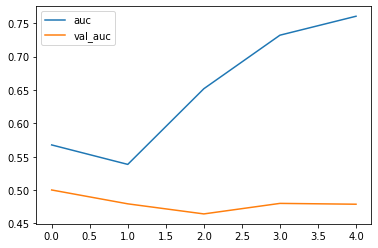

In [24]:
losses[['auc','val_auc']].plot()

<AxesSubplot:>

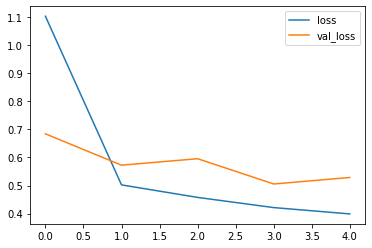

In [25]:
losses[['loss','val_loss']].plot()

In [26]:
preds = model.predict(validation_dataset).flatten()

In [27]:
binary_preds = (preds > 0.5).astype(int)
confusion_matrix(validation_labels, binary_preds)

array([[4445,   37],
       [ 474,    6]])

In [28]:
print(classification_report(validation_labels, binary_preds))

              precision    recall  f1-score   support

           0       0.90      0.99      0.95      4482
           1       0.14      0.01      0.02       480

    accuracy                           0.90      4962
   macro avg       0.52      0.50      0.48      4962
weighted avg       0.83      0.90      0.86      4962



In [29]:
# submission_pred = model.predict(test_examples).flatten()
# submission_pred

In [30]:
# submission = pd.DataFrame([test_labels, submission_pred], index=['id','target']).T
# submission